In [196]:
import numpy as np
import pandas as pd
from collections import defaultdict
from scapy.all import *
from IPy import IP as IPy
import pprint
from sklearn import preprocessing
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

from dask.distributed import Client, progress
import dask.dataframe as dd
#import dask.bag as db
client = Client('127.0.0.1:8786')
client

Client Scheduler: tcp://127.0.0.1:8786 Dashboard: http://127.0.0.1:8787,Cluster Workers: 4 Cores: 16 Memory: 68.72 GB


# Preparing the training set

In [211]:
sydney_1M_preprocessed = pd.read_csv("./sydney_1M_preprocessed.csv")
sydney_1M_preprocessed

,eth,sentence,label
0,00:24:e4:1b:6f:96,device Withings 1B6F96 68 udp:bootp 342 <EOS> ...,Withings Scale
1,08:21:ef:3b:fc:e3,device Samsung-Electronics-CoLtd 3BFCE3 37796 ...,Samsung Tablet
2,18:b4:30:25:be:e4,device Nest-Labs-Inc 25BEE4 68 udp:bootp 350 <...,Nest Smoke Alarm
3,00:24:e4:11:18:a8,device Withings 1118A8 37802 tcp 66 service Wi...,Withings Baby Monitor
4,18:b7:9e:02:20:44,device Invoxia 022044 40234 tcp:data 70 servic...,Triby Speaker
5,44:65:0d:56:cc:d3,device Amazon-Technologies-Inc 56CCD3 60958 ud...,Amazon Echo
6,74:2f:68:81:69:42,device AzureWave-Technology-Inc 816942 68 udp:...,Azure Laptop
7,f4:f2:6d:93:51:f1,device TP-LINK-TECHNOLOGIES-COLTD 9351F1 49335...,TP-Link Camera
8,14:cc:20:51:33:ea,device TP-LINK-TECHNOLOGIES-COLTD 5133EA 53 dn...,TP-Link Router
9,30:8c:fb:2f:e4:b2,device Dropcam 2FE4B2 46330 ssl 156 service Dr...,Dropcam Camera


In [212]:
#remove eth, switch the order and encode the labels
sydney_1M_for_training = sydney_1M_preprocessed[['label','sentence']].copy()

In [213]:
labels = pd.concat([sydney_1M_preprocessed['label'], daghan_preprocessed['label']], ignore_index= True)
le = preprocessing.LabelEncoder()
le.fit(labels)

sydney_1M_for_training['label'] = le.fit_transform(sydney_1M_for_training['label'])
sydney_1M_for_training['label'] = sydney_1M_for_training['label'].apply(lambda x: '__label__' + str(x))
sydney_1M_for_training

,label,sentence
0,__label__21,device Withings 1B6F96 68 udp:bootp 342 <EOS> ...
1,__label__15,device Samsung-Electronics-CoLtd 3BFCE3 37796 ...
2,__label__9,device Nest-Labs-Inc 25BEE4 68 udp:bootp 350 <...
3,__label__20,device Withings 1118A8 37802 tcp 66 service Wi...
4,__label__19,device Invoxia 022044 40234 tcp:data 70 servic...
5,__label__0,device Amazon-Technologies-Inc 56CCD3 60958 ud...
6,__label__3,device AzureWave-Technology-Inc 816942 68 udp:...
7,__label__16,device TP-LINK-TECHNOLOGIES-COLTD 9351F1 49335...
8,__label__17,device TP-LINK-TECHNOLOGIES-COLTD 5133EA 53 dn...
9,__label__7,device Dropcam 2FE4B2 46330 ssl 156 service Dr...


In [214]:
sydney_1M_for_training.to_csv('sydney_1M_for_training.txt', header=None, index=None, sep=' ')

# Training the model

In [215]:
! ../fastText/fasttext supervised -input sydney_1M_for_training.txt -output sydney

Read 4M words
Number of words:  15173
Number of labels: 22
Progress: 100.0% words/sec/thread: 1379214 lr:  0.000000 loss:  2.820754 ETA:   0h 0m


# Preparing the testing set

In [229]:
daghan_preprocessed = pd.read_csv("./daghan_preprocessed.csv")
daghan_preprocessed

,eth,sentence,label
0,00:18:0a:12:2f:2d,device Cisco-Meraki 122F2D 34948 tcp 70 servic...,Meraki Phone
1,b8:e9:37:8c:da:3c,device Sonos-Inc 8CDA3C 41371 tcp 70 service S...,Sonos Speaker
2,28:f0:76:31:d3:58,device Apple-Inc 31D358 65474 tcp 64 service A...,Apple Computer
3,40:cb:c0:bc:36:7e,device Apple-Inc BC367E 5353 mdns 790 40CBC0BC...,Apple TV
4,44:65:0d:90:60:3a,device Amazon-Technologies-Inc 90603A 55151 ud...,Amazon Echo
5,78:28:ca:32:4b:28,device Sonos-Inc 324B28 43082 ssdp 530 1900 <...,Sonos Speaker
6,38:c9:86:40:7c:a6,device Apple-Inc 407CA6 icmp:data 102 device ...,Apple Computer
7,84:38:35:5a:70:40,device Apple-Inc 5A7040 59554 ssl 172 service ...,Apple Computer
8,5c:aa:fd:4c:87:a0,device Sonos-Inc 4C87A0 44689 ssl 105 service ...,Sonos Speaker
9,78:28:ca:03:80:0c,device Sonos-Inc 03800C 57006 http 378 service...,Sonos Speaker


In [232]:
daghan_for_testing = daghan_preprocessed.drop(['eth','label'], axis = 1)
daghan_for_testing

,sentence
0,device Cisco-Meraki 122F2D 34948 tcp 70 servic...
1,device Sonos-Inc 8CDA3C 41371 tcp 70 service S...
2,device Apple-Inc 31D358 65474 tcp 64 service A...
3,device Apple-Inc BC367E 5353 mdns 790 40CBC0BC...
4,device Amazon-Technologies-Inc 90603A 55151 ud...
5,device Sonos-Inc 324B28 43082 ssdp 530 1900 <...
6,device Apple-Inc 407CA6 icmp:data 102 device ...
7,device Apple-Inc 5A7040 59554 ssl 172 service ...
8,device Sonos-Inc 4C87A0 44689 ssl 105 service ...
9,device Sonos-Inc 03800C 57006 http 378 service...


In [235]:
daghan_for_testing.to_csv('daghan_for_testing.txt', header=None, index=None, sep=' ')
! head -n 1 ./daghan_for_testing.txt

"device Cisco-Meraki 122F2D 34948 tcp 70 service Cisco-Meraki 7011 <EOS> device Cisco-Meraki 122F2D 34949 tcp 70 service Cisco-Meraki 7011 <EOS> device Cisco-Meraki 122F2D 34948 ssl 619 service Cisco-Meraki 7011 <EOS> device Cisco-Meraki 122F2D 34949 ssl 619 service Cisco-Meraki 7011 <EOS> device Cisco-Meraki 122F2D 60663 tcp 70 service Cisco-Meraki 5021 <EOS> "


# Prediction

In [236]:
!../fastText/fasttext predict sydney.bin daghan_for_testing.txt > daghan_predictions.txt

In [240]:
predicted_labels = pd.read_csv("./daghan_predictions.txt", header = None)
predicted_labels.columns = ['label']
predicted_labels.label = predicted_labels.label.apply(lambda x: x.split('__')[-1])

Ignore the warning above. 
It will be fixed in the next release of scikit
https://stackoverflow.com/questions/48687375/deprecation-error-in-sklearn-about-empty-array-without-any-empty-array-in-my-cod

In [241]:
import warnings
warnings.filterwarnings('ignore')
predicted_labels.label = predicted_labels.label.apply(lambda x: le.inverse_transform(int(x)))
#predicted_labels

In [242]:
predicted_labels['true label'] = daghan_preprocessed['label']
predicted_labels

,label,true label
0,Samsung Tablet,Meraki Phone
1,TP-Link Camera,Sonos Speaker
2,Android Phone,Apple Computer
3,TP-Link Router,Apple TV
4,Amazon Echo,Amazon Echo
5,Samsung Camera,Sonos Speaker
6,TP-Link Router,Apple Computer
7,Android Phone,Apple Computer
8,Samsung Tablet,Sonos Speaker
9,Withings Scale,Sonos Speaker


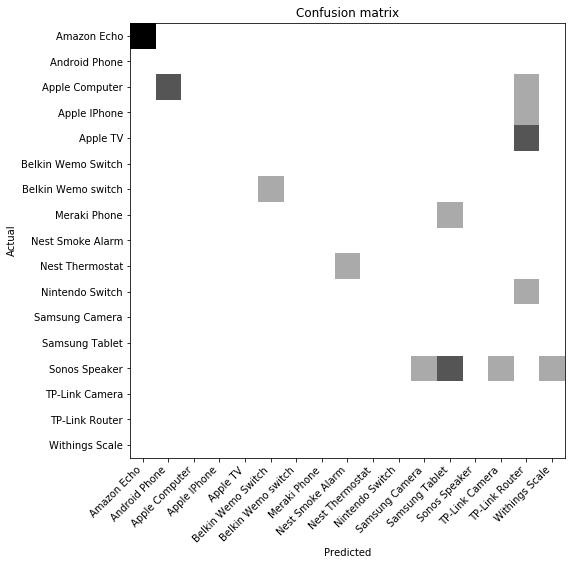

In [243]:
from pandas_ml import ConfusionMatrix
import matplotlib.pyplot as plt

confusion_matrix = ConfusionMatrix(daghan_preprocessed.label,predicted_labels.label)
confusion_matrix.plot()

# Try TensorFlow

## Prepare the labels

In [259]:
labels = pd.concat([sydney_1M_preprocessed['label'], daghan_preprocessed['label']], ignore_index= True)
le = preprocessing.LabelEncoder()
le.fit(labels)
#final_agg_df['label'] = le.transform(final_agg_df['eth'])
#final_agg_df = final_agg_df.drop(['eth'], axis=1)

LabelEncoder()

In [260]:
sydney_1M_preprocessed['label'] = le.transform(sydney_1M_preprocessed['label'])
daghan_preprocessed['label'] = le.transform(daghan_preprocessed['label'])

In [263]:
# Training input on the whole sydney 1M set with no limit on training epochs.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    sydney_1M_preprocessed, sydney_1M_preprocessed["label"], num_epochs=None, shuffle=True)

# Prediction on the whole sydney 1M set.
predict_train_input_fn = tf.estimator.inputs.pandas_input_fn(
    sydney_1M_preprocessed, sydney_1M_preprocessed["label"], shuffle=False)

# Prediction on daghan
predict_test_input_fn = tf.estimator.inputs.pandas_input_fn(
    daghan_preprocessed, daghan_preprocessed["label"], shuffle=False)

embedded_text_feature_column = hub.text_embedding_column(
    key="sentence", 
    module_spec="https://tfhub.dev/google/nnlm-en-dim128/1",
    trainable = True)

In [264]:
estimator = tf.estimator.DNNClassifier(
    hidden_units=[500, 100],
    feature_columns=[embedded_text_feature_column],
    n_classes=len(le.classes_),
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.003))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/2r/9kw2cykj317_f5bzwgspyfbr0000gn/T/tmpb9djs_88', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c8d8cde48>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
estimator.train(input_fn=train_input_fn, steps=1000);

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Initialize variable dnn/input_from_feature_columns/input_layer/sentence_hub_module_embedding/module/embeddings/part_0:0 from checkpoint b'/var/folders/2r/9kw2cykj317_f5bzwgspyfbr0000gn/T/tfhub_modules/32f2b2259e1cc8ca58c876921748361283e73997/variables/variables' with embeddings
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/2r/9kw2cykj317_f5bzwgspyfbr0000gn/T/tmpb9djs_88/model.ckpt.
INFO:tensorflow:loss = 1241.9089, step = 1
INFO:tensorflow:Saving checkpoints for 48 into /var/folders/2r/9kw2cykj317_f5bzwgspyfbr0000gn/T/tmpb9djs_88/model.ckpt.
INFO:tensorflow:Saving checkpoints for 98 into /var/folders/2r/9kw2cykj317_f5bzwgspyfbr0000gn/T/tmpb9djs_88/model.ckpt.
INFO:tensorflow:global_step/sec: 0.080158
INFO:tensorflow:loss = 0

In [ ]:
train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
print("Training set accuracy: {accuracy}".format(**train_eval_result))

In [ ]:
test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)
print("Test set accuracy: {accuracy}".format(**test_eval_result))